# Desafío 2

Importo bibliotecas y leo el dataset. En este caso, trabajo con el dataset da la obra de Romeo y Julieta, descargada como texto plano de *The Project Gutenberg eBook*. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

In [3]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df_original = pd.read_csv('Romeo_and_Juliet.txt', sep='/n', header=None)
df_original.head()

C:\Users\javier\AppData\Local\Temp\ipykernel_33620\2801571640.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_original = pd.read_csv('Romeo_and_Juliet.txt', sep='/n', header=None)


,0
0,The Project Gutenberg eBook of Romeo and Juliet
1,This ebook is for the use of anyone anywhere i...
2,most other parts of the world at no cost and w...
3,"whatsoever. You may copy it, give it away or r..."
4,of the Project Gutenberg License included with...


In [4]:
# Limpio la obra (saco parte del texto que no es relevante en el analisis)
# Busco el inicio y el final de la obra
start_idx = df_original[df_original[0].str.contains(r'\*\*\* START OF', na=False)].index[0]
end_idx = df_original[df_original[0].str.contains(r'\*\*\* END OF', na=False)].index[0]

df = df_original.iloc[start_idx + 1:end_idx].reset_index(drop=True)
df.head()

,0
0,THE TRAGEDY OF ROMEO AND JULIET
1,by William Shakespeare
2,Contents
3,THE PROLOGUE.
4,ACT I


In [5]:
# Imprimo cantidad de documentos dentro del corpus
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 4137


In [6]:
#!pip install --upgrade tensorflow
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [7]:
# Demos un vistazo
sentence_tokens[:2]

[['the', 'tragedy', 'of', 'romeo', 'and', 'juliet'],
 ['by', 'william', 'shakespeare']]

Defino la clase *callback* vista en la teoría y le agrego el atributo `losses` para graficar la pérdida en función de las épocas de entrenamiento.

In [8]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
            self.losses.append(loss)
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
            self.losses.append(loss - sum(self.losses))
        self.epoch += 1
        self.loss_previous_step = loss

In [9]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,           # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,              # cant de palabras antes y desp de la predicha
                     vector_size=400,       # dimensionalidad de los vectores 
                     negative=20,           # cantidad de negative samples... 0 es no se usa
                     workers=4,             # si tienen más cores pueden cambiar este valor
                     sg=1)                  # modelo 0:CBOW  1:skipgram

In [10]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [11]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 4137


In [12]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 698


Loss after epoch 0: 78538.6640625
Loss after epoch 1: 46622.2109375
Loss after epoch 2: 45324.03125
Loss after epoch 3: 46873.140625
Loss after epoch 4: 45565.765625
Loss after epoch 5: 46198.625
Loss after epoch 6: 45818.625
Loss after epoch 7: 45489.28125
Loss after epoch 8: 45563.8125
Loss after epoch 9: 41713.15625
Loss after epoch 10: 44865.9375
Loss after epoch 11: 44735.75
Loss after epoch 12: 44559.5
Loss after epoch 13: 43687.5625
Loss after epoch 14: 43084.9375
Loss after epoch 15: 43152.875
Loss after epoch 16: 42987.5
Loss after epoch 17: 42263.4375
Loss after epoch 18: 41997.75
Loss after epoch 19: 41624.375
Loss after epoch 20: 40924.625
Loss after epoch 21: 39896.25
Loss after epoch 22: 40493.6875
Loss after epoch 23: 37159.625
Loss after epoch 24: 36380.375
Loss after epoch 25: 36380.625
Loss after epoch 26: 36238.625
Loss after epoch 27: 32368.125
Loss after epoch 28: 35598.75
Loss after epoch 29: 35782.25
Loss after epoch 30: 35274.75
Loss after epoch 31: 35028.125
Lo

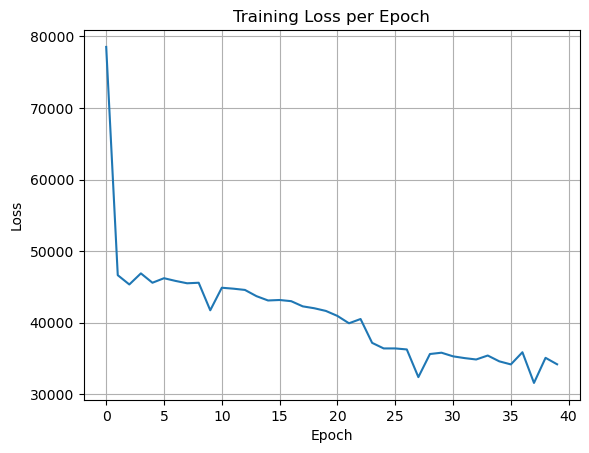

In [13]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback

loss_logger = callback()

w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=40,
                 compute_loss = True,
                 callbacks=[loss_logger]
                 )


plt.plot(loss_logger.losses)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Relaciones entre palabras! Pruebo términos de interés como **Romeo** y analizo la relación semántica que tiene con otros términos dentro del corpus y su relación narrativa dentro de la obra.

In [14]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["romeo"], topn=10)

[('prince', 0.7928198575973511),
 ('mercutio’s', 0.7838296294212341),
 ('already', 0.778189480304718),
 ('slew', 0.7776015400886536),
 ('anon', 0.7637309432029724),
 ('mercutio', 0.7551029920578003),
 ('chorus', 0.7179713249206543),
 ('falls', 0.7041217088699341),
 ('wherefore', 0.6998388171195984),
 ('noble', 0.6966948509216309)]

Estas son las *10 palabras (tokens) con más relación de contexto respecto a **Romeo**.  
Palabras (tokens) como **mercutio’s** y **prince**, por ejemplo, son las que más veces aparecen cerca de *Romeo* en el texto (corpus).  
Un ejemplo de esto es la línea (documento):  

> *"Not Romeo, Prince, he was Mercutio’s friend;"*  

También aparecen otras palabras relacionadas como **slew**, **already**, **anon**, que comparten contexto con Romeo en distintas escenas.  
Asimismo, se destacan términos como **chorus**, **noble**, **falls** y **wherefore**, cuya presencia frecuente cerca de *Romeo* sugiere una asociación estadística significativa aprendida por el modelo.

Esto refleja cómo el modelo Word2Vec captura asociaciones basadas en coocurrencia dentro del texto de la obra (corpus).

*El valor de similitud puede variar de corrida a corrida por la aleatoriedad de los entrenamientos.

Ahora analizo la relación entre **Romeo** y **Julieta**. Es esperable que tengan una alta relación (alta similitud).

In [15]:
w2v_model.wv.similarity('romeo', 'juliet')

0.67551464

Tal como puede verse, y era de esperar, la similitud coseno entre estos dos tokens es alta!

In [16]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["romeo"], topn=10)

[('eyes', -0.1271466463804245),
 ('nor', -0.1372544914484024),
 ('doth', -0.13855257630348206),
 ('eye', -0.14249779284000397),
 ('an', -0.1426222026348114),
 ('on', -0.17393651604652405),
 ('hands', -0.18078546226024628),
 ('own', -0.18172883987426758),
 ('thine', -0.18346959352493286),
 ('upon', -0.18731610476970673)]

Estas son las 10 palabras que tienen mayor **relación negativa** con el token **romeo**, según el modelo.  
Palabras como **tears** o **eyes** aparecen en contextos diferentes a los de *Romeo*.  
Por ejemplo, **tears** (no se muestra en todas las ejecuciones dentro de las 10 menos similares, aunque tiene alta similitud) se asocia más con escenas emocionales o con otros personajes.

Ahora paso a los gráficos.

In [17]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model, num_dimensions = 2 ):
     
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [ ]:
# Graficar los embedddings en 2D
#!pip install plotly
!pip install -U kaleido
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.write_image("embeddings.png")
fig.show() 

c:\Users\javier\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\javier\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\javier\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\javier\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\javier\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.Crea

ValueError: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido


Se aprecia similitud entre tokens como **face**, **eyes** y **tears**, tanto desde el punto de vista semántico como lógico, ya que es esperable encontrar estas palabras en contextos similares. En este sentido, el modelo de embeddings logra reflejar relaciones intuitivas del lenguaje.

También se observa proximidad entre palabras como **father** y **lord**, y entre **wife** y **lady**, así como entre los cuatro términos en conjunto.

Vale destacar que las representaciones en 2D (al igual que en 3D) pueden variar entre ejecuciones, ya que pequeños cambios en los vectores originales pueden provocar grandes diferencias en las proyecciones obtenidas mediante PCA. 

In [ ]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.write_html("embeddings_3d.html")
fig.show() 

En el gráfico 3D se aprecian relaciones similares a las del gráfico 2D, como por ejemplo entre **face**, **eyes** y **tears**. Sin embargo, al estar en tres dimensiones, resulta un poco más difícil interpretar visualmente la cercanía entre tokens.

Es importante tener en cuenta que tanto en el gráfico 2D como en el 3D se están proyectando los vectores en un espacio de dimensión mucho menor que la original (400), por lo que las distancias mostradas no siempre reflejan con fidelidad las relaciones del modelo de embeddings.